### Integral BL code for cylinder

In [1]:
#ntime=cfl*dx/ttime                                                             
ntime=100
cfl= 0.2
ncell = 100
dx = pi/real(ncell)
ttime = 1.
time = 0.005
uinf = 1.
c = 1.
re = 1000

x = zeros(ncell+2)
ue = zeros(ncell+2)
uex = zeros(ncell+2)
uet = zeros(ncell+2)
#Set sources                                                                    
for i = 2:ncell+1
    x[i] = real(i-2)*dx + 0.5*dx
    ue[i] = 2*sin(x[i])
    uex[i] = 2*cos(x[i])
end 

uet[1:ncell+2] = 0

ue[1] = 10e-6
ue[ncell+2] = 10e-6
uex[1] = cos(0.)
uex[ncell+2] = cos(pi)

E = zeros(ncell+2)
B = zeros(ncell+2)
del = zeros(ncell+2)
F = zeros(ncell+2)
dfde = zeros(ncell+2)
S = zeros(ncell+2)
unk = zeros(2,ncell+2)


#Set initial conditions                                                         
E[:] = 0.4142
B = 131.9*E.^3 - 167.32*E.^2 + 76.642*E - 11.068
del = sqrt(B*time)
F = 4.8274*E.^4 - 5.9816*E.^3 + 4.0274*E.^2 + 0.23247*E + 0.15174

unk[1,:] = del
unk[2,:] = del.*(E + 1)

function FfromE(E::Float64)
      F = 4.8274*E^4 - 5.9816*E^3 + 4.0274*E^2 + 0.23247*E + 0.15174
end

function BfromE(E::Float64)
    if E < -0.0616
        B = -225.86*E^3 - 3016.6*E^2 - 208.68*E - 17.915 
    elseif E > -0.0395
        B = 131.9*E^3 - 167.32*E^2 + 76.642*E - 11.068
    else
        B = 0.5*(-225.86*E^3 - 3016.6*E^2 - 208.68*E - 17.915 + 131.9*E^3 - 167.32*E^2 + 76.642*E - 11.068)
    end
end

function SfromE(E::Float64)
    if E < -0.0582
        S = 451.55*E^3 + 2010.*E^2 + 138.96*E + 11.296
    elseif E > -0.042
        S = -96.739*E^3 + 117.74*E^2 - 46.432*E + 6.8074
    else
        S = 0.5*(451.55*E^3 + 2010.*E^2 + 138.96*E + 11.296 - 96.739*E^3 + 117.74*E^2 - 46.432*E + 6.8074)
    end
end

function dfdefromE(E::Float64)
    dfde = 4*4.8274*E^3 - 3*5.9816*E^2 + 2*4.0274*E + 0.23247
end

function calcdt(cfl::Float64, lamb::Array{Float64,2})
    dt = 10000
    for ic = 1:size(lamb,2)
        dti = cfl*(dx/(abs(lamb[1,ic]) + abs(lamb[2,ic])))
        if dti < dt
            dt=dti
        end 
    end 
    return dt
end

function calcEigen(ue::Vector{Float64}, E::Vector{Float64}, F::Vector{Float64}, dfde::Vector{Float64})
    ncell = length(E) - 2
    lamb = zeros(2,ncell+2)
    for ic = 1:ncell+2
        aq = 1.
        bq = -ue[ic]*(dfde[ic] - 1.)
        cq = ue[ic]*ue[ic]*(E[ic]*dfde[ic] - F[ic])
        lamb[1,ic] = (-bq + sqrt(bq*bq - 4*aq*cq))/(2*aq)
        lamb[2,ic] = (-bq - sqrt(bq*bq - 4*aq*cq))/(2*aq)

        #Always have lamb1 > lamb2                                                
        if lamb[2,ic] > lamb[1,ic]
            temp  = lamb[2,ic]
            lamb[2,ic] = lamb[1,ic]
            lamb[1,ic] = temp
        end         
    end
    return lamb
end

calcEigen (generic function with 1 method)

In [2]:
function calc_flux(lamb::Array{Float64,2}, ue::Vector{Float64}, E::Vector{Float64}, del::Vector{Float64})
    ncell = length(ue) - 2
    flux = zeros(2,2,ncell+2)
    Apos = zeros(2,2)
    
    for ic = 1:ncell+2
        if lamb[1,ic] >= 0. && lamb[2,ic] >= 0.
            flux[1,1,ic] = ue[ic]*E[ic]*del[ic]
            flux[1,2,ic] = ue[ic]*F[ic]*del[ic]
        elseif lamb[1,ic] < 0. && lamb[2,ic] < 0.
            flux[1,:,ic] = 0.
            else
            Apos[1,1] = (ue[ic]*lamb[1,ic]/(lamb[1,ic] - lamb[2,ic]))*(-1. - lamb[2,ic]/ue[ic])       
            Apos[1,2] = ue[ic]*lamb[1,ic]/(lamb[1,ic] - lamb[2,ic])
            Apos[2,1] = -(ue[ic]*lamb[1,ic]/(lamb[1,ic] - lamb[2,ic]))*(1 + lamb[1,ic]/ue[ic])*(1 + lamb[2,ic]/ue[ic])
            Apos[2,2] = (ue[ic]*lamb[1,ic]/(lamb[1,ic] - lamb[2,ic]))*(1 + lamb[1,ic]/ue[ic])
            flux[1,1,ic] =  Apos[1,1]*del[ic] + Apos[1,2]*(E[ic] + 1.)*del[ic]
            flux[1,2,ic] = Apos[2,1]*del[ic] + Apos[2,2]*(E[ic] + 1.)*del[ic]
        end
    end
    for ic = 1:ncell+2
        if lamb[1,ic] >= 0. && lamb[2,ic] >= 0.
            flux[2,:,ic] = 0.
         elseif lamb[1,ic] < 0. && lamb[2,ic] < 0.
            flux[2,1,ic] = ue[ic]*E[ic]*del[ic]
            flux[2,2,ic] = ue[ic]*F[ic]*del[ic]
         else
            Aneg[1,1] = (ue[ic]*lamb[2,ic]/(lamb[1,ic] - lamb[2,ic]))*(1. + lamb[1,ic]/ue[ic])
            Aneg[1,2] = -ue[ic]*lamb[2,ic]/(lamb[1,ic] - lamb[2,ic])
            Aneg[2,1] = (ue[ic]*lamb[2,ic]/(lamb[1,ic] - lamb[2,ic]))*(1. + lamb[1,ic]/ue[ic])*(1. + lamb[2,ic]/ue[ic])
            Aneg[2,2] = (ue[ic]*lamb[2,ic]/(lamb[1,ic] - lamb[2,ic]))*(-1. - lamb[2,ic]/ue[ic])
            flux[2,1,ic] = Aneg[1,1]*del[ic] + Aneg[1,2]*(E[ic] + 1.)*del[ic]
            flux[2,2,ic] = Aneg[2,1]*del[ic] + Aneg[2,2]*(E[ic] + 1.)*del[ic]
         end
    end
    return flux
end

        

calc_flux (generic function with 1 method)

In [3]:
lamb = zeros(2,ncell+2)
unkt = zeros(2,ncell+2)
unkh = zeros(2,ncell+2)
rhs = zeros(2,ncell+2)
flux = zeros(2,2,ncell+2)
crit = zeros(ncell+2)
Apos = zeros(2,2)
Aneg = zeros(2,2)
nstage = 2

2

In [4]:
#Main loop over time steps
for i = 1:ntime
#i = 1
    unk[:,1] = 2*unk[:,2] - unk[:,3]
    unk[:,ncell+2] = 2*unk[:,ncell+1] - unk[:,ncell]
    #Calculate derived quantities                                                
    for ic = 1:ncell+2
        del[ic] = unk[1,ic]
        E[ic] = (unk[2,ic]./del[ic]) - 1.
        F[ic] = FfromE(E[ic])
        B[ic] = BfromE(E[ic])    
        S[ic] = SfromE(E[ic]) 
        dfde[ic] = dfdefromE(E[ic])
    end 

    #Compute eigenvalues                                                         
    lamb = calcEigen(ue, E, F, dfde)
    
    #Compute timestep
    dt = calcdt(cfl, lamb)
    
    #Compute fluxes
    flux = calc_flux(lamb, ue, E, del)

    #compute rhs
    for ic = 2:ncell+1
        rhs[1,ic] = B[ic]/(2*del[ic]) - del[ic]*uet[ic]/ue[ic] - (E[ic] + 1.)*del[ic]*uex[ic]
        rhs[2,ic] = S[ic]/del[ic] - 2*E[ic]*del[ic]*uet[ic]/ue[ic] - 2*F[ic]*del[ic]*uex[ic]
    end
    
    for ic = 2:ncell
        unkh[1,ic] = unk[1,ic] - (dt/dx)*(flux[1,1,ic] - flux[1,1,ic-1] + flux[2,1,ic+1] 
        - flux[2,1,ic]) + dt*rhs[1,ic]
        unkh[2,ic] = unk[2,ic] - (dt/dx)*(flux[1,2,ic] - flux[1,2,ic-1] + flux[2,2,ic+1] 
        - flux[2,2,ic]) + dt*rhs[2,ic]
    end
    ic = ncell+1
    unkh[1,ic] = unk[1,ic] - (dt/dx)*(flux[1,1,ic] - flux[1,1,ic-1]) + dt*rhs[1,ic]
    unkh[2,ic] = unk[2,ic] - (dt/dx)*(flux[1,2,ic] - flux[1,2,ic-1]) + dt*rhs[2,ic]
    
    #Update ghost cells       
    unkh[:,1] = 2*unkh[:,2] - unkh[:,3]
    unkh[:,ncell+2] = 2*unkh[:,ncell+1] - unkh[:,ncell]
    
    #Calculate derived quantities
    for ic = 1:ncell+2
        del[ic] = unk[1,ic]
        E[ic] = (unk[2,ic]./del[ic]) - 1.
        F[ic] = FfromE(E[ic])
        B[ic] = BfromE(E[ic])    
        S[ic] = SfromE(E[ic]) 
        dfde[ic] = dfdefromE(E[ic])
    end 
    
    #Compute eigenvalues                                                         
    lamb = calcEigen(ue, E, F, dfde)
    
    #Compute fluxes
    fluxhalf = calc_flux(lamb, ue, E, del)

    #compute rhs
    for ic = 2:ncell+1
        rhs[1,ic] = B[ic]/(2*del[ic]) - del[ic]*uet[ic]/ue[ic] - (E[ic] + 1.)*del[ic]*uex[ic]
        rhs[2,ic] = S[ic]/del[ic] - 2*E[ic]*del[ic]*uet[ic]/ue[ic] - 2*F[ic]*del[ic]*uex[ic]
    end
    
    ic = 2
    unk[1,ic] = 0.5*(unk[1,ic] + unkh[1,ic]) - (0.5*dt/dx)*(flux[1,1,ic] - flux[1,1,ic-1] 
    - flux[2,1,ic] + 2*flux[2,1,ic+1] - flux[2,1,ic+2] + fluxhalf[1,1,ic] - fluxhalf[1,1,ic-1] 
    + fluxhalf[2,1,ic+1] - fluxhalf[2,1,ic]) + 0.5*dt*rhs[1,ic]
    unk[2,ic] = 0.5*(unk[2,ic] + unkh[2,ic]) - (0.5*dt/dx)*(flux[1,2,ic] - flux[1,2,ic-1] 
    - flux[2,2,ic] + 2*flux[2,2,ic+1] - flux[2,2,ic+2] + fluxhalf[1,2,ic] - fluxhalf[1,2,ic-1] 
    + fluxhalf[2,2,ic+1] - fluxhalf[2,2,ic]) + 0.5*dt*rhs[2,ic]
    for ic = 3:ncell
        unk[1,ic] = 0.5*(unk[1,ic] + unkh[1,ic]) - (0.5*dt/dx)*(flux[1,1,ic] - 2*flux[1,1,ic-1] + 
        flux[1,1,ic-2] - flux[2,1,ic] + 2*flux[2,1,ic+1] - flux[2,1,ic+2] + fluxhalf[1,1,ic] 
        -fluxhalf[1,1,ic-1] + fluxhalf[2,1,ic+1] - fluxhalf[2,1,ic]) + 0.5*dt*rhs[1,ic]
        unk[2,ic] = 0.5*(unk[2,ic] + unkh[2,ic]) - (0.5*dt/dx)*(flux[1,2,ic] - 2*flux[1,2,ic-1] 
        + flux[1,2,ic-2] - flux[2,2,ic] + 2*flux[2,2,ic+1] - flux[2,2,ic+2] + fluxhalf[1,2,ic] 
        - fluxhalf[1,2,ic-1] + fluxhalf[2,2,ic+1] - fluxhalf[2,2,ic]) + 0.5*dt*rhs[2,ic]
    end
    ic = ncell+1
    unk[1,ic] = 0.5*(unk[1,ic] + unkh[1,ic]) - (0.5*dt/dx)*(flux[1,1,ic] - 2*flux[1,1,ic-1] 
    + flux[1,1,ic-2] +fluxhalf[1,1,ic] - fluxhalf[1,1,ic-1]) + 0.5*dt*rhs[1,ic]
    unk[2,ic] = 0.5*(unk[2,ic] + unkh[2,ic]) - (0.5*dt/dx)*(flux[1,2,ic] - 2*flux[1,2,ic-1] 
    + flux[1,2,ic-2] +fluxhalf[1,2,ic] - fluxhalf[1,2,ic-1]) + 0.5*dt*rhs[2,ic]
    
    time = time + dt
    if time > ttime
        quit()
    end
    
    for ic = 2:ncell+1
        crit[ic] = abs((del[ic+1] - del[ic])/(del[ic] - del[ic-1]))
        if abs(crit[ic]) > 10.
            println(x[ic]," ", ue[ic]," ", crit[ic])
        end 
    end
    
end

        
            
      
                
   

3.0944687637859465 0.09421290141928503 10.406365982653648
3.0944687637859465 0.09421290141928503 11.843868350950743
3.0944687637859465 0.09421290141928503 13.573567330869528


In [9]:
time

0.37854908283662403

In [7]:
using PyPlot

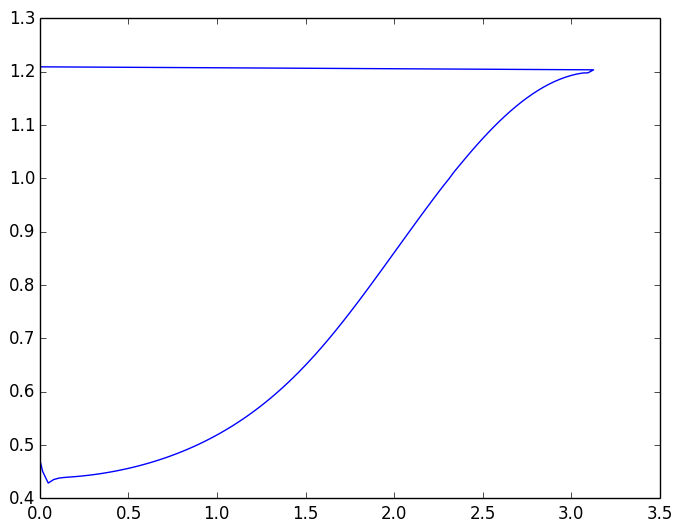

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x321610410>

In [8]:
plot(x,del)

In [ ]:
rhs